In [148]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy

import matplotlib.animation as animation
import IPython

import torch.distributions as tdist

from ipywidgets import interact

from utils import GaussianFamilyOn2DGaussianPosterior, VariationalInference

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


$\newcommand{\elbo}{\mathrm{ELBO}}$
$\newcommand{\kl}{\mathrm{KL}}$
$\newcommand{\set}[1]{ \left\{ #1 \right\}}$
$\def\R{{\mathbb R}}$
$\def\Q{{\mathbb Q}}$
$\def\E{{\mathbb E}}$
$\def\C{{\mathbb C}}$
$\def\N{{\mathbb N}}$
$\def\Z{{\mathbb Z}}$

$\newcommand{\brac}[1]{\left(#1\right)}$
$\newcommand{\abs}[1]{\left|\, #1\,\right|}$
$\newcommand{\p}{\partial}$
$\newcommand{\abrac}[1]{\left\langle #1 \right\rangle}$
$\newcommand{\sqbrac}[1]{\left[ #1 \right]}$
$\newcommand{\st}{\, \, : \,}$
$\newcommand{\supp}{\mathrm{supp}}$
$\newcommand{\norm}[1]{\lVert #1 \rVert}$
$\renewcommand{\d}[1]{\, \mathrm{d}#1 \,}$

# Unit tests (Making sure that code works as intended)

## Unit test 1: Gaussian family VI to learn known Gaussian posterior
Will try to do variational inference against toy Gaussian posterior to make sure that the code has intended behaviour. 

We will attempt to approximate the normal distribution 
$$
p(\xi) = \frac{1}{(2\pi)^{d/2} \sqrt{\mathrm{det}(\sigma_0^2I_d)}} e^{\frac{1}{2\sigma_0^2}\sum_{j = 1}^d (\xi_j - \mu_{0j})^2}. 
$$

We shall find a distribution from the following Gaussian family
$$
\mathcal{Q}_{gaussian} = \set{q_{\mu, \sigma}(\xi) = \frac{1}{(2\pi)^{d/2} \sqrt{\mathrm{det}(\sigma^2I_d)}} e^{\frac{1}{2\sigma^2}\sum_{j = 1}^d (\xi_j - \mu_{j})^2} \st \mu \in \R^d, \sigma \in \R_{> 0}}
$$


In this case, we have ELBO given by 
$$
-\elbo(q) = \E_q\sqbrac{\log \frac{q(\xi)}{e^{-\frac{1}{2\sigma_0^2}\sum_j (\xi_j - \mu_{0j})^2}}} = \E_q \log q(\xi) + \frac{1}{2\sigma_0^2} \E_q \sum_j (\xi_j - \mu_{0j})^2
$$

In [47]:
class GaussianFamilyOn2DGaussianPosterior(VariationalInference):
    
    def __init__(self, mu_0, sigma_0, lr=0.001, base_samples=100):
        self.mu_0 = mu_0
        self.sigma_0 = sigma_0
        self.true_parameters = [mu_0, sigma_0]
        
        self.mu = nn.Parameter(torch.tensor([.1, .9], dtype=torch.float))
        self.logsigma = nn.Parameter(torch.tensor([np.log(0.9)], dtype=torch.float))
        self.parameters = [self.mu, self.logsigma]
        
        self.optim = torch.optim.Adam(self.parameters, lr=lr)
        self.base_samples = base_samples
        super(GaussianFamilyOn2DGaussianPosterior, self).__init__(self.parameters, self.true_parameters, self.optim)
        
    def elbo_fn(self):
        q = tdist.MultivariateNormal(loc=self.mu, covariance_matrix=torch.eye(2) * torch.exp(2 * self.logsigma))
        xi = q.rsample((self.base_samples, ))
        term1 = q.log_prob(xi)
        term2 = torch.sum((xi - self.mu_0)**2, dim=1) / (2 * self.sigma_0**2)
        return -torch.mean(term1 + term2)
    
    def report_optim_step(self):
        print(
            f"Epoch {self.epoch:5d}: mu={np.around(self.mu.detach().tolist(), 2)}, "
            f"sigma={torch.exp(self.logsigma).item():.3f}, elbo={self.elbo:.2f}"
        )

    def true_unnormalised_density(self, w):
        q = tdist.MultivariateNormal(loc=self.mu_0, covariance_matrix=torch.eye(2) * self.sigma_0)
        z = np.exp(q.log_prob(w))
        return z
    
    def variational_density(self, w, parameters):
        mu, logsigma = parameters
        q = tdist.MultivariateNormal(loc=mu, covariance_matrix=torch.eye(2) * torch.exp(2 * logsigma))
        z = np.exp(q.log_prob(w))
        return z

Epoch     1: mu=[0.1 0.9], sigma=0.899, elbo=-1.68
Epoch   101: mu=[0.19 0.8 ], sigma=0.819, elbo=-1.09
Epoch   201: mu=[0.27 0.72], sigma=0.755, elbo=-0.22
Epoch   301: mu=[0.34 0.64], sigma=0.704, elbo=0.05
Epoch   401: mu=[0.39 0.57], sigma=0.662, elbo=0.18
Epoch   501: mu=[0.43 0.51], sigma=0.629, elbo=0.29
Epoch   601: mu=[0.46 0.46], sigma=0.602, elbo=0.25
Epoch   701: mu=[0.47 0.42], sigma=0.579, elbo=0.37
Epoch   801: mu=[0.49 0.39], sigma=0.562, elbo=0.44
Epoch   901: mu=[0.49 0.36], sigma=0.548, elbo=0.44


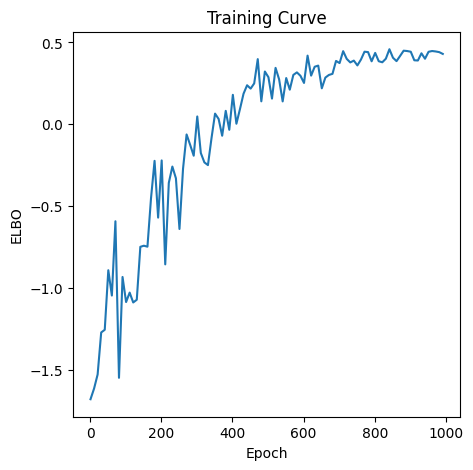

In [48]:
gaussian_vi = GaussianFamilyOn2DGaussianPosterior(
    mu_0=torch.tensor([0.5, 0.3]), 
    sigma_0=torch.tensor([0.5])
)
gaussian_vi.run_parameter_optimisation(1000)
fig = gaussian_vi.plot_training_curve();

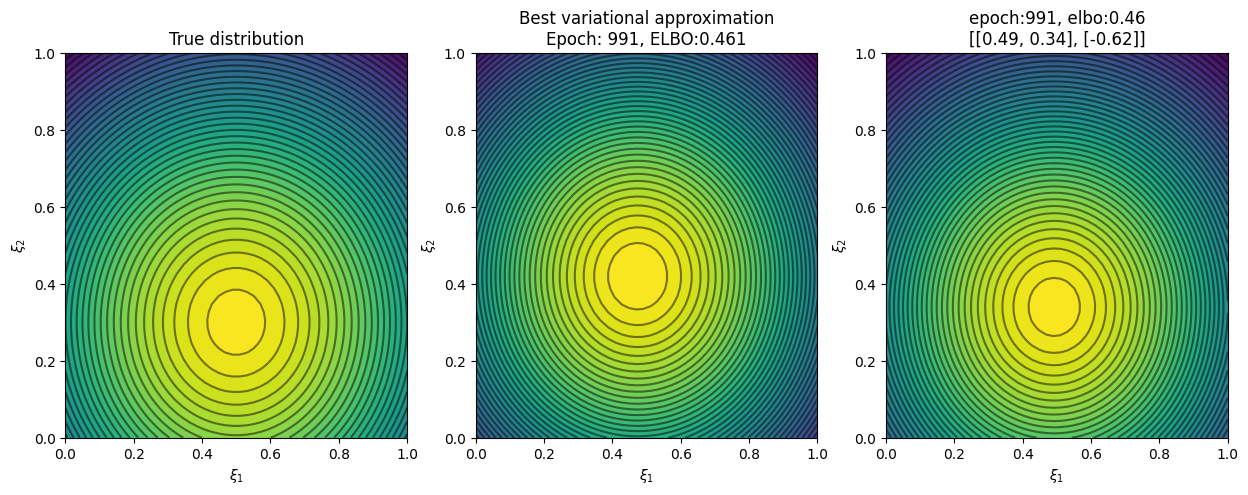

In [46]:
fig, video = gaussian_vi.plot_variational_posterior(animate=True);
IPython.display.display(IPython.display.HTML(video))


## Unit test 2: Mean field generalised gamma family to learn mean field generalised gamma

Here we try to use a mean-field generalised gamma family to learn a known generalised gamma distribution: 
$$
p(\xi) = \prod_{j = 1}^2 \frac{\beta_{0j}^{\lambda_{0j}}}{\Gamma(\lambda_{0j})} \xi_j^{2k_{0j}\lambda_{0j} - 1} e^{-\beta_{0j}\xi_j^{2k_{0j}}}
$$

The mean-field generalised gamma variational family is given by
$$
\mathcal{Q}_{gamma} := \set{
q_{\theta}(\xi) = \prod_{j = 1}^2 \frac{2k_j\beta_j^{\lambda_j}}{\gamma(\lambda_j, \beta_j)\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} \st \theta = (\lambda_1, \lambda_2, k_1, k_2, \beta_1, \beta_2) \in \R^{3d}_{\geq 0}}
$$

In this case, we have ELBO given by 
$$
-\elbo(q) = \E_q\sqbrac{\log \frac{q(\xi)}{\prod_{j = 1}^2 \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} }} = \E_q \log q(\xi) + \frac{1}{2\sigma_0^2} \E_q \sum_j (\xi_j - \mu_{0j})^2
$$

# Experiment 1: Learning 2D standard form posterior 

## Experiment 1.0: Learning with Gaussian Family

We are assuming that our posterior is of the form 
$$
p(\xi_1, \xi_2) = \frac{1}{\overline{Z}_n} \xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}}, \quad (\xi_1, \xi_2) \in [0, 1]^2
$$
where $\overline{Z}_n = \int_{[0, 1]^2} \xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}} d\xi_1 d\xi_2$ is the normalising constant, a.k.a. the evidence.  

The posterior contours would look like the following:

In [63]:
N = 200
xx, yy = np.meshgrid(np.linspace(0, 1, num=N), np.linspace(0, 1, num=N))
w = np.stack((xx, yy), axis=-1)

@interact(
    n=(2, 10000),
    k1=(0, 5),
    k2=(0, 5),
    h1=(0, 5),
    h2=(0, 5)
)
def _plot_contour(n=500, k1=2, k2=3, h1=1, h2=2):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    h = np.array([h1, h2])
    k = np.array([k1, k2])
    z = np.abs(np.prod(w**h, axis=-1)) * np.exp(-n * np.prod(w ** (2 * k), axis=-1))
    normalising_const = np.sum(z) / (N**2)
    lambdas = (h + 1) / (2 * k)
    rlct = np.min(lambdas)
    m = np.sum(lambdas == rlct)
    const_term = (
        scipy.special.loggamma(rlct) 
        - np.log(scipy.special.factorial(m -1)) 
        - np.log(2 * k1) - np.log(2 * k2)
    )
    ks = [k1, k2]
    hs = [h1, h2]
    j = np.argmax(lambdas)
    if m == 1:
        const_term -= np.log(-2 * rlct * ks[j] + hs[j] + 1)
    print(
        f"-logZ = {-np.log(normalising_const)}\n"
        f"RLCT  = {rlct}\n"
        f"m     = {m}\n"
        f"const = {const_term}\n"
        f"rlct log(n) - (m - 1) log log n = {rlct * np.log(n) - (m -1) * np.log(np.log(n))}"
    )
    ax.contourf(xx, yy, z / normalising_const, levels=100)
    ax.set_xlabel("$\\xi_1$")
    ax.set_ylabel("$\\xi_2$")

interactive(children=(IntSlider(value=500, description='n', max=10000, min=2), IntSlider(value=2, description=…

Given a variational family $\mathcal{Q}$, we wish to find a variational approximation $\hat{q} \in \mathcal{Q}$ that minimises the KL-divergence $KL(\hat{q} || p(\xi_1, \xi_2)$. Notice though that this is equivalent to maximising the ELBO = Evidence Lower Bound: 
$$
\elbo(q)= -\E_q\sqbrac{n\xi^{2k}} - \E_q \log \frac{q(\xi)}{\xi^h} \\
$$

This can be shown by the following calculation. 
$$
\begin{align*}
  \kl(q||p) 
  &= \E_q\log \frac{q(\xi)}{p(\xi)}\\
  &= \log \overline{Z}_n + \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}}} \\
  &= \log \overline{Z}_n + \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}\\
\end{align*}
$$
Since $\kl(q||p) \geq 0$, we can bound the log-evidence with 
$$
  \log \overline{Z}_n \geq -\E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} - \E_q n \xi_1^{2k_1} \xi_2^{2k_2} =: \elbo(q)
$$

## Gaussian Variational Family
We shall first use a simple Gaussian family of distribution for variational inference. 
$$
\mathcal{Q}_{gaussian} := \set{q_{\mu_1, \mu_2, \sigma}(\xi) = \frac{1}{2\pi \sigma^2} e^{-\frac{1}{2\sigma^2} \sqbrac{(\xi_1 - \mu_1)^2 + (\xi_2 - \mu_2)^2}} \st \mu_1, \mu_2 \in \R, \sigma \in (0, \infty)}
$$

To maximise $\elbo(q)$ for $q \in \mathcal{Q}_{gaussian}$ via gradient descent on the variational parameters $\theta = (\mu_1, \mu_2, \sigma)$, we need unbiased estimate for the gradient $\nabla_{\theta} \elbo(q)$. We can apply the reparametrisation trick to the above gaussian family as follow, for each $j = 1, 2$
 1. We sample noise $\epsilon_j$ independently from $N(0, 1)$. 
 2. Set $\xi_j = \mu_j + \sigma \epsilon_j$. 

This construction implies that $\xi_j \sim N(\mu_j, \sigma^2)$ and $(\xi_1, \xi_2) \sim q_\theta$. We can then estimate the gradient of ELBO as
$$
\begin{align*}
  -\nabla_\theta \elbo(q_\theta) 
  &= \nabla_\theta \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}\\
  &= \nabla_\theta \E_q\log q(\xi) -  \E_q \log(\xi_1^{h_1} \xi_2^{h_2}) + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}
\end{align*}
$$

In [152]:
class GaussianFamilyOn2DStandardForm(VariationalInference):
    
    def __init__(self, n, k_0, h_0, lr=0.001, base_samples=100):
        self.n = n
        self.k_0 = k_0
        self.h_0 = h_0
        self.true_parameters = [k_0, h_0]
        self.mu = nn.Parameter(torch.tensor([.1, .9], dtype=torch.float))
        self.logsigma = nn.Parameter(torch.tensor([np.log(0.3)], dtype=torch.float))
#         self.mu = nn.Parameter(torch.rand(2, dtype=torch.float))
#         self.logsigma = nn.Parameter(torch.log(1 + torch.rand(1, dtype=torch.float)))
        self.parameters = [self.mu, self.logsigma]
        
        self.optim = torch.optim.Adam(self.parameters, lr=lr)
        self.base_samples = base_samples
        super(GaussianFamilyOn2DStandardForm, self).__init__(self.parameters, self.true_parameters, self.optim)
        
    def elbo_fn(self):
        q = tdist.MultivariateNormal(loc=self.mu, covariance_matrix=torch.eye(2) * torch.exp(2 * self.logsigma))
        xi = q.rsample((self.base_samples, ))
        term1 = q.log_prob(xi)
        term2 = torch.sum(torch.log(torch.abs(xi)) * self.h_0, dim=1)
        term3 = self.n * torch.prod(xi**(2 * self.k_0), dim=1)
        elbo = -torch.mean(term1 - term2 + term3)
        return elbo
    
    def report_optim_step(self):
        print(
            f"Epoch {self.epoch:6d}: mu={np.around(self.mu.detach().tolist(), 2)}, "
            f"sigma={torch.exp(self.logsigma).item():.3f}, elbo={self.elbo:.2f}"
        )

    def true_unnormalised_density(self, w):
        z = torch.abs(torch.prod(w**self.h_0, dim=-1)) * torch.exp(-n * torch.prod(w ** (2 * self.k_0), dim=-1))
        return z
    
    def variational_density(self, w, parameters):
        mu, logsigma = parameters
        q = tdist.MultivariateNormal(loc=mu, covariance_matrix=torch.eye(2) * torch.exp(2 * logsigma))
        z = np.exp(q.log_prob(w))
        return z

gaussian_on_standard_form = GaussianFamilyOn2DStandardForm(
    n=500,
    k_0=torch.tensor([2, 3]), 
    h_0=torch.tensor([1, 2]), 
    lr=0.001
)

Epoch      1: mu=[0.1 0.9], sigma=0.300, elbo=-50.64
Epoch   1501: mu=[0.03 0.63], sigma=0.240, elbo=-5.67
Epoch   3001: mu=[-0.02  0.61], sigma=0.221, elbo=-4.32
Epoch   4501: mu=[-0.06  0.6 ], sigma=0.211, elbo=-4.13
Epoch   6001: mu=[-0.04  0.6 ], sigma=0.207, elbo=-4.18
Epoch   7501: mu=[-0.01  0.64], sigma=0.204, elbo=-4.13
Epoch   9001: mu=[0.03 0.66], sigma=0.201, elbo=-4.11
Epoch  10501: mu=[0.03 0.65], sigma=0.196, elbo=-3.93
Epoch  12001: mu=[0.03 0.61], sigma=0.208, elbo=-3.89
Epoch  13501: mu=[0.03 0.58], sigma=0.209, elbo=-4.14


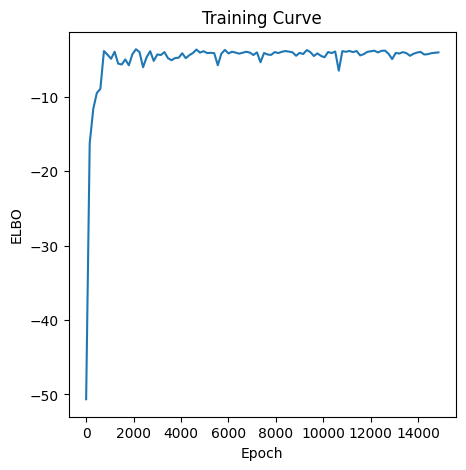

In [153]:
gaussian_on_standard_form.run_parameter_optimisation(15000)
fig = gaussian_on_standard_form.plot_training_curve();

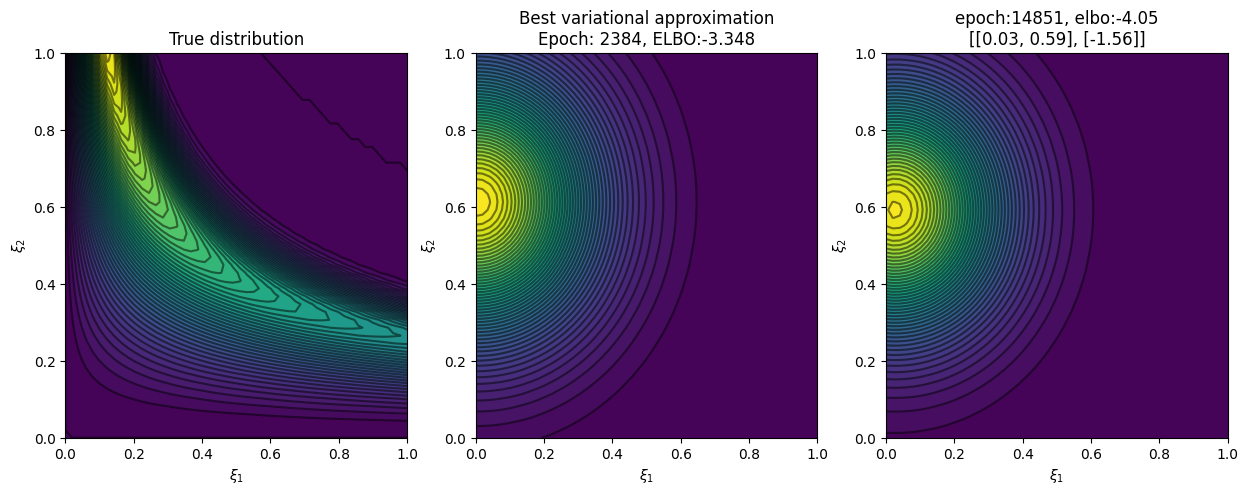

In [154]:
fig, video = gaussian_on_standard_form.plot_variational_posterior(animate=True);
IPython.display.display(IPython.display.HTML(video))


# Experiment 2: Learning 2D standard form with Gamma Mean Field Family

## Generalised Gamma Mean Field Family
Our variational family in this case is a mean field family of generalised gamma distributions.
$$
\mathcal{Q}_{gamma} := \set{
q_{\theta}(\xi) = \prod_{j = 1}^2 \frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} \st \theta = (\lambda_1, \lambda_2, k_1, k_2, \beta_1, \beta_2) \in \R^{3d}_{\geq 0}, \xi \in [0, \infty)}
$$

To maximise $\elbo(q)$ for $q \in \mathcal{Q}_{gaussian}$ via gradient descent on the variational parameters $\theta = (\mu_1, \mu_2, \sigma)$, we need unbiased estimate for the gradient $\nabla_{\theta} \elbo(q)$. We can apply the reparametrisation trick to the above gaussian family as follow, for each $j = 1, 2$
 1. We sample noise $\epsilon_j$ independently from $N(0, 1)$. 
 2. Set $\xi_j = \mu_j + \sigma \epsilon_j$. 

This construction implies that $\xi_j \sim N(\mu_j, \sigma^2)$ and $(\xi_1, \xi_2) \sim q_\theta$. We can then estimate the gradient of ELBO as
$$
\begin{align*}
  - \elbo(q_\theta) 
  &= \E_q n \xi_1^{2k_{01}} \xi_2^{2k_{02}} + \E_q\log \frac{q(\xi)}{\xi_1^{h_{01}} \xi_2^{h_{02}}}\\
\end{align*}
$$

The first term is given by (with $d = 2$ below)
$$
\begin{align*}
\E_q n \xi_1^{2k_1} \xi_2^{2k_2}
&= n \prod_{j = 1}^d \int_0^\infty q_j(\xi_j) \xi_j^{2k_{0j}} d\xi_j\\
&= n \prod_{j = 1}^d \frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda_j)} \int_0^\infty \xi_j^{2k_j \lambda_j -2k_{0j} -1} e^{-\beta_j \xi_j^{2k_j}} d\xi_j \\
&= n \prod_{j = 1}^d \frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda_j)} \frac{1}{2k_j\beta_j^{\lambda_j + \frac{k_{0j}}{k_j}}}\Gamma\brac{\lambda_j + \frac{k_{0j}}{k_j}}\\
&= n \prod_{j = 1}^d \frac{1}{ \beta_j^{k_{0j} / k_j}}\frac{\Gamma\brac{\lambda_j + \frac{k_{0j}}{k_j}}}{\Gamma(\lambda_j)}
\end{align*}
$$

The second term is given by 
$$
\begin{align*}
\E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}}
&= \sum_{j = 1}^d \int_0^\infty q_j(\xi_j) \log \frac{q(\xi_j)}{\xi_j^{2\lambda_{0j} k_{0j} -1}}d\xi_j\\
&= \sum_{j = 1}^d \int_0^\infty q_j(\xi_j) \log \frac{\frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}}}{\xi_j^{2\lambda_{0j} k_{0j} -1}}d\xi_j\\
&= \sum_{j = 1}^d \log\brac{\frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda)} } 
- \beta_j \int_0^\infty q(\xi_j) \xi_j^{2k_j} d\xi_j
+ \brac{2k_j \lambda_j - 2k_{0j}\lambda_{0j}}\int_0^\infty q_j(\xi_j) \log \xi_j d\xi_j\\
&=  \sum_{j = 1}^d 
\log(2k_j) + \lambda_j\log \beta_j - \log \Gamma(\lambda)
- \beta_j \frac{\beta_j^{\lambda_j}2k_j}{\Gamma(\lambda_j)} \frac{\Gamma(\lambda_j + 1)}{2k_j \beta_j^{\lambda_j + 1}}
+ \brac{2k_j \lambda_j - 2k_{0j}\lambda_{0j}}\int_0^\infty q_j(\xi_j) \log \xi_j d\xi_j\\
&=  \sum_{j = 1}^d 
\log(2k_j) + \lambda_j\log \beta_j - \log \Gamma(\lambda)
- \lambda_j
+ \brac{2k_j \lambda_j - 2k_{0j}\lambda_{0j}}\frac{1}{2k_j}\brac{\psi(\lambda_j) - \log \beta_j}\\
&=  \sum_{j = 1}^d 
\log(2k_j) + \lambda_j\log \beta_j - \log \Gamma(\lambda)
- \lambda_j
+ \brac{\lambda_j - \frac{k_{0j}}{k_j}\lambda_{0j}}\brac{\psi(\lambda_j) - \log \beta_j}. 
\end{align*}
$$

To evaluate $\E_{q_j}\log \xi_j$, we have use the following observation 
$$
\frac{d}{d\lambda}\Gamma(\lambda) = \int_0^\infty e^{-t} \frac{d}{d\lambda}t^{\lambda -1} dt = \int_0^\infty e^{-t} t^{\lambda -1} \log t dt
$$
and hence, using the substitution $t =\beta \xi^{2k}$
$$
\begin{align*}
\E_{q} \log \xi 
&= \frac{2k\beta^{\lambda}}{\Gamma(\lambda)}\int_0^\infty e^{-\beta \xi^{2k}} \xi^{2\lambda k - 1} \log \xi d\xi\\
&= \frac{2k\beta^{\lambda}}{\Gamma(\lambda)}\int_0^\infty e^{-t} \brac{\frac{t}{\beta}}^{\lambda - 1/(2k)} \log\brac{\frac{t}{\beta}}^{1/(2k)} \frac{t^{1/(2k) - 1}}{2k\beta^{1/(2k)}} dt\\
&= \frac{2k\beta^{\lambda}}{\Gamma(\lambda)}\frac{1}{4k^2 \beta^\lambda}\int_0^\infty e^{-t} t^{\lambda -1} \brac{\log t - \log \beta}dt\\
&= \frac{1}{2k\Gamma(\lambda)}\brac{\int_0^\infty e^{-t} t^{\lambda -1} \log t dt - \log \beta \int_0^\infty e^{-t}t^{\lambda -1} dt}\\
&= \frac{1}{2k\Gamma(\lambda)}\brac{\Gamma'(\lambda) - \Gamma(\lambda)\log \beta }\\
&= \frac{1}{2k}\brac{\frac{\Gamma'(\lambda)}{\Gamma(\lambda)} - \log \beta}\\
&= \frac{1}{2k}\brac{\psi(\lambda) - \log \beta}\\
\end{align*}
$$

In [ ]:
class MeanFieldGammaOn2DStandardForm(VariationalInference):
    
    def __init__(self, n, k_0, lambda_0, lr=0.001, base_samples=100):
        self.n = n
        self.k_0 = k_0
        self.lambda_0 = lambda_0
        self.h_0 = 2 * k_0 * lambda_0 - 1
        self.true_parameters = [lambda_0, k_0, n]
        
        self.loglambdas = nn.Parameter(torch.log(lambda_0))
        self.logks = nn.Parameter(torch.log(k_0))
        self.logbetas = nn.Parameter(torch.log(torch.tensor([n, 1.])))
        self.parameters = [self.loglambdas, self.logks, self.logbetas]
        
        self.optim = torch.optim.Adam(self.parameters, lr=lr)
        super(MeanFieldGammaOn2DStandardForm, self).__init__(self.parameters, self.true_parameters, self.optim)
        
    def elbo_fn(self):
        lambdas, ks, betas = [torch.exp(param) for param in self.parameters]
        r = self.k_0 / ks
        
        term1 = self.n * torch.exp(torch.sum(
            -r * torch.log(betas) +  torch.lgamma(lambdas + r) - torch.lgamma(lambdas)
        ))
        
        term2 = torch.sum(
            torch.log(2 * ks) + lambdas * torch.log(betas) 
            - torch.lgamma(lambdas) - lambdas 
            + (lambdas - r * self.lambda_0) * (torch.digamma(lambdas) - torch.log(betas))
        )
        return -term1 - term2
    
    def report_optim_step(self):
        lambdas, ks, betas = [torch.exp(param).detach() for param in self.parameters]

        print(
            f"Epoch {self.epoch:5d}: elbo={self.elbo:.2f}\n"
            f"lambdas={list(np.around(lambdas.tolist(), 2))}\n"
            f"ks     ={list(np.around(ks.tolist(), 2))}\n"
            f"betas  ={list(np.around(betas.tolist(),2))}\n"
        )

    def true_unnormalised_density(self, w):
        z = torch.abs(torch.prod(w**self.h_0, dim=-1)) * torch.exp(-n * torch.prod(w ** (2 * self.k_0), dim=-1))
        return z
    
    def variational_density(self, w, parameters):
        lambdas, ks, betas = [torch.exp(param).detach().numpy() for param in parameters]
        w = w.numpy()
        z = w ** (2 * ks * lambdas - 1) * np.exp(-betas * (w**ks))
        normalising_const = scipy.special.gamma(lambdas) / ( 2 * ks * (betas ** (lambdas)))
        z = np.prod(z / normalising_const, axis=-1)
        return z

    

n        = 1000
lambda_0 = tensor([0.3400, 0.8000])
ks_0     = tensor([20,  3])

Epoch     1: elbo=-5.87
lambdas=[0.34, 0.8]
ks     =[20.02, 3.0]
betas  =[999.0, 1.0]

Epoch  1001: elbo=-0.14
lambdas=[1.23, 3.21]
ks     =[6.51, 0.58]
betas  =[3836.6, 0.27]

Epoch  2001: elbo=99.73
lambdas=[12.75, 22.13]
ks     =[0.48, 0.07]
betas  =[47988.47, 0.04]

Epoch  3001: elbo=1170.76
lambdas=[112.83, 172.38]
ks     =[0.05, 0.01]
betas  =[499550.88, 0.01]

Epoch  4001: elbo=2005.29
lambdas=[192.81, 365.48]
ks     =[0.03, 0.01]
betas  =[895349.5, 0.0]

Epoch  5001: elbo=2282.46
lambdas=[216.51, 506.19]
ks     =[0.03, 0.01]
betas  =[1039700.81, 0.0]

Epoch  6001: elbo=2895.33
lambdas=[268.96, 840.51]
ks     =[0.02, 0.01]
betas  =[1380420.12, 0.0]

Epoch  7001: elbo=3884.83
lambdas=[378.69, 1572.46]
ks     =[0.01, 0.0]
betas  =[2295279.5, 0.0]

Epoch  8001: elbo=4084.50
lambdas=[385.17, 1603.69]
ks     =[0.01, 0.0]
betas  =[2278803.5, 0.0]

Epoch  9001: elbo=4378.04
lambdas=[394.79, 1652.66]
ks    

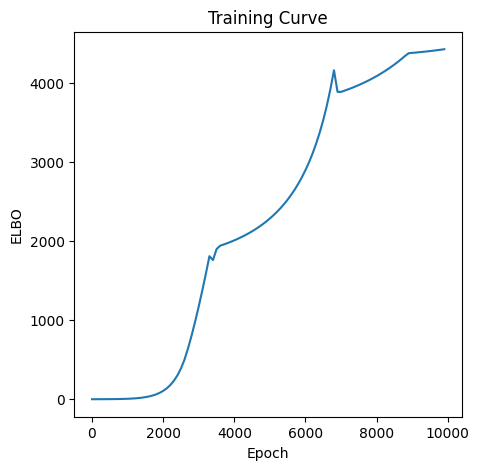

In [142]:
n = 1000
k_0 = torch.tensor([20, 3])  # assume no "flat" dimensions with k_j = 0
lambda_0 = torch.tensor([12/35, 16/20])
h_0 = 2 * k_0 * lambda_0 - 1

print(
    f"n        = {n}\n"
    f"lambda_0 = {np.around(lambda_0.detach(), 2)}\n"
    f"ks_0     = {np.around(k_0.detach(), 2)}\n"
)

mean_field_gamma_on_standard_form = MeanFieldGammaOn2DStandardForm(
    n=n,
    k_0=k_0,
    lambda_0 = torch.tensor([12/35, 16/20])
)

mean_field_gamma_on_standard_form.run_parameter_optimisation(10000)
mean_field_gamma_on_standard_form.plot_training_curve();

/tmp/ipykernel_224354/2348654161.py:49: RuntimeWarning: overflow encountered in power
  normalising_const = scipy.special.gamma(lambdas) / ( 2 * ks * (betas ** (lambdas)))
/tmp/ipykernel_224354/2348654161.py:49: RuntimeWarning: invalid value encountered in divide
  normalising_const = scipy.special.gamma(lambdas) / ( 2 * ks * (betas ** (lambdas)))
/home/edmund/.local/share/virtualenvs/variational-approximation-for-singular-mod-T_CFu1la/lib/python3.9/site-packages/matplotlib/contour.py:1479: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/edmund/.local/share/virtualenvs/variational-approximation-for-singular-mod-T_CFu1la/lib/python3.9/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/edmund/variational-approximation-for-singular-models/notebooks/utils.py:88: UserWarning: No contour levels were found within the data range.
  contour = ax.contour(xx, yy, z, lev

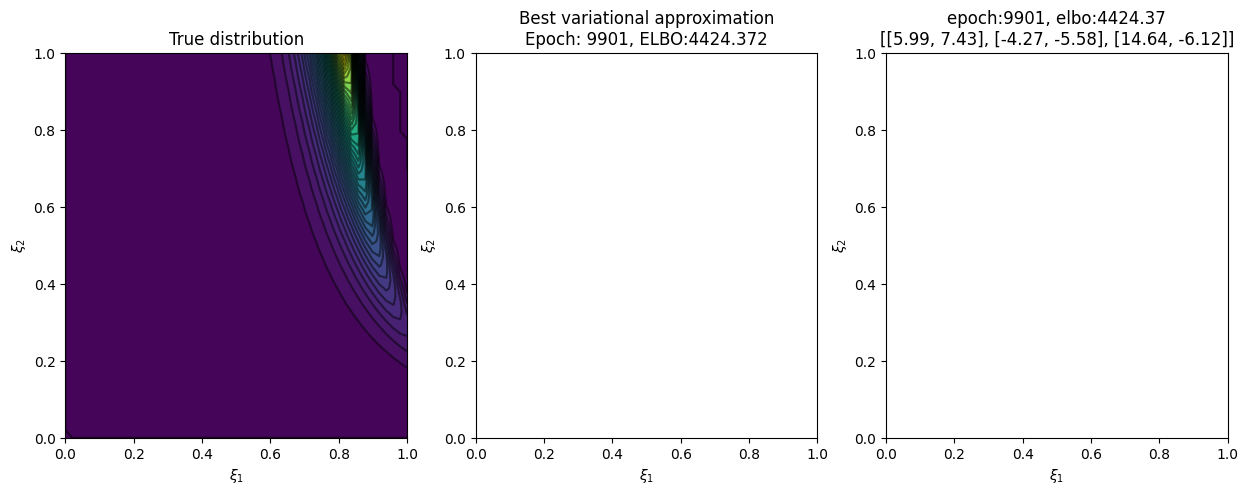

In [131]:
fig, video = mean_field_gamma_on_standard_form.plot_variational_posterior(animate=True);
IPython.display.display(IPython.display.HTML(video))


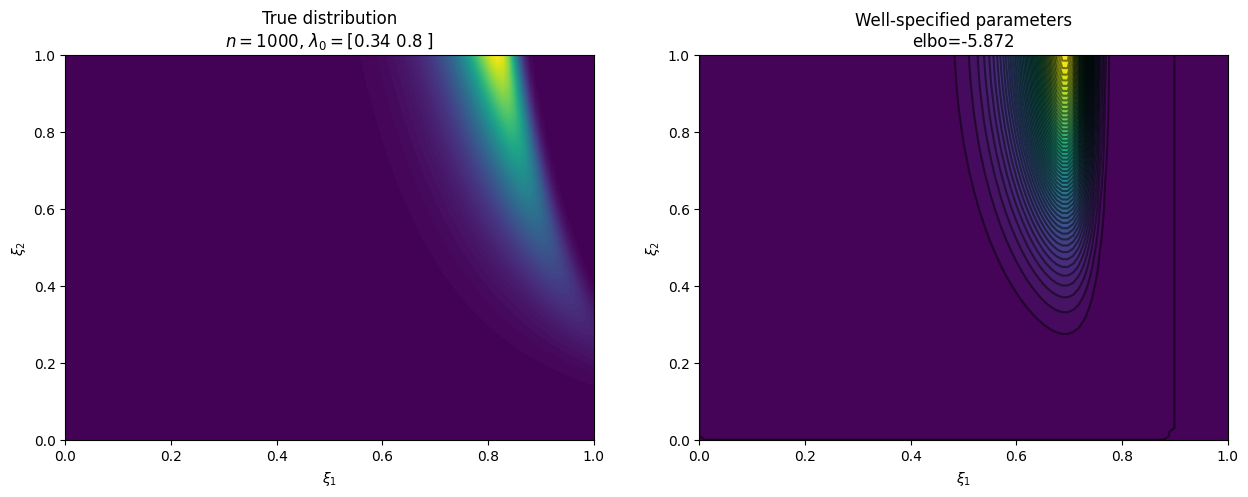

In [140]:
def elbo_func(lambdas, ks, betas, lambdas_0, ks_0, n):
    r = ks_0 / ks
    term1 = n * torch.exp(torch.sum(
        -r * torch.log(betas) +  torch.lgamma(lambdas + r) - torch.lgamma(lambdas)
    ))
    term2 = torch.sum(
        torch.log(2 * ks) + lambdas * torch.log(betas) 
        - torch.lgamma(lambdas) - lambdas 
        + (lambdas - r * lambdas_0) * (torch.digamma(lambdas) - torch.log(betas))
    )
    return -term1 - term2

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
N = 100
levels = 50
a, b = 0, 1
xx, yy = torch.meshgrid(torch.linspace(a, b, N), torch.linspace(a, b, N))
w = torch.stack((xx, yy), dim=-1)


ax = axes[0]
z = mean_field_gamma_on_standard_form.true_unnormalised_density(w)
ax.contourf(xx, yy, z, levels=100)
ax.set_xlabel("$\\xi_1$")
ax.set_ylabel("$\\xi_2$")
ax.set_title(f"True distribution\n$n=${n}, $\\lambda_0=${str(np.around(lambda_0.numpy(), 2))}")


ax = axes[1]
loglambdas = torch.log(lambda_0)
logks = torch.log(k_0)
logbetas = torch.log(torch.tensor([n, 1]))
z = mean_field_gamma_on_standard_form.variational_density(w, [loglambdas, logks, logbetas])

contourf = ax.contourf(xx, yy, z, levels=levels)
contour = ax.contour(xx, yy, z, levels=levels, colors='k', alpha=0.5)
ax.set_xlabel("$\\xi_1$")
ax.set_ylabel("$\\xi_2$")
elbo = elbo_func(lambda_0, k_0, torch.exp(logbetas), lambda_0, k_0, n).detach().numpy()
ax.set_title(f"Well-specified parameters\nelbo={elbo:.3f}");


# Experiment 3: Learning 2D standard form with Truncated Generalised Gamma Mean Field Family
Our variational family in this case is a mean field family of truncated generalised gamma distributions.
$$
\mathcal{Q}_{gamma} := \set{
q_{\theta}(\xi) = \prod_{j = 1}^2 \frac{2k_j\beta_j^{\lambda_j}}{\gamma(\lambda_j, \beta_j)\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} \st \theta = (\lambda_1, \lambda_2, k_1, k_2, \beta_1, \beta_2) \in \R^{3d}_{\geq 0}, \xi \in [0, 1)}
$$

# Experiment 4: Learning high dimension standard form, comparing Generalised Gamma Mean Field Family with Gaussian Family